In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so


In [2]:
df_train = pd.read_csv("train.csv")
df_train.head()


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [3]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [4]:
clarity_rank = [
    "FL",
    "IF",
    "VVS1",
    "VVS2",
    "VS1",
    "VS2",
    "SI1",
    "SI2",
    "I1",
    "I2",
    "I3",
]
color_rank = ["D", "E", "F", "G", "H", "I", "J"]
cut_rank = ["Ideal", "Premium", "Very Good", "Good", "Fair"]


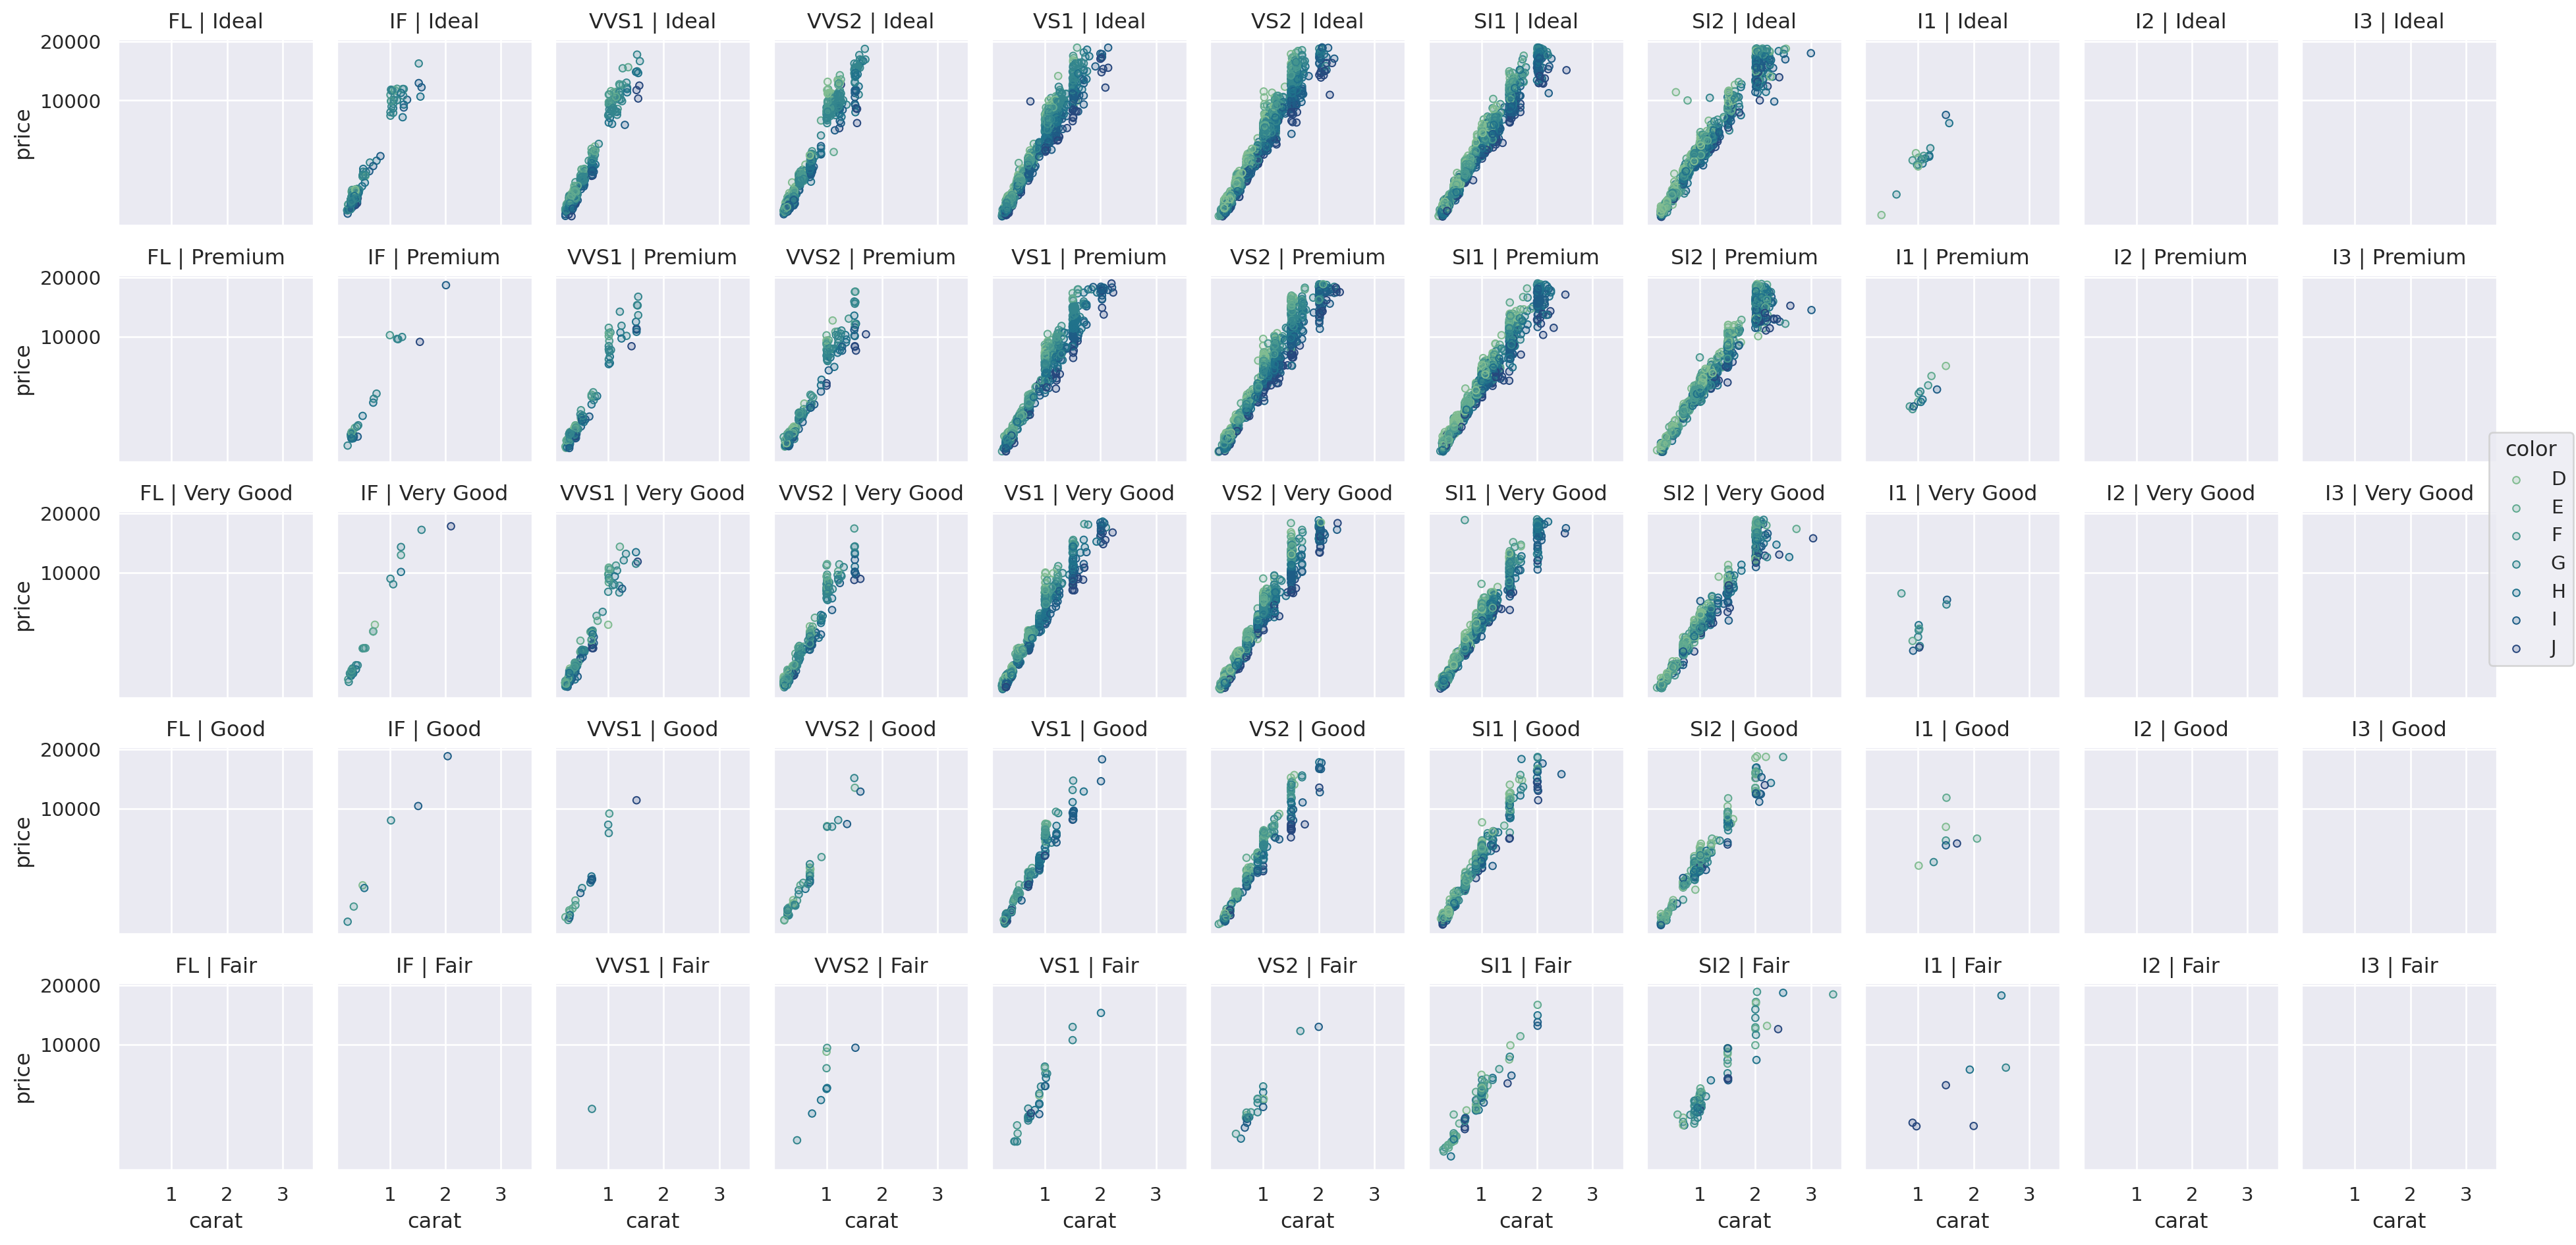

In [5]:
df = df_train.head(20000)
# df = df[(df.carat < 0.8) & (df.carat >= 0.6)]

# df["root_price_per_carat"] = (df.price - df.price.min()).apply(np.sqrt)
(
    so.Plot(df, x="carat", y="price", color="color")
    .facet(col="clarity", row="cut", order={"col": clarity_rank, "row": cut_rank})
    .add(so.Dots())
    # .add(so.Lines(), y="predicted_price")
    .scale(
        y = so.Continuous(trans="sqrt"),
        color=so.Nominal(values="crest", order=color_rank),
    )
    .layout(size=(20, 10))
    # .limit(y=(0, 2000))
)


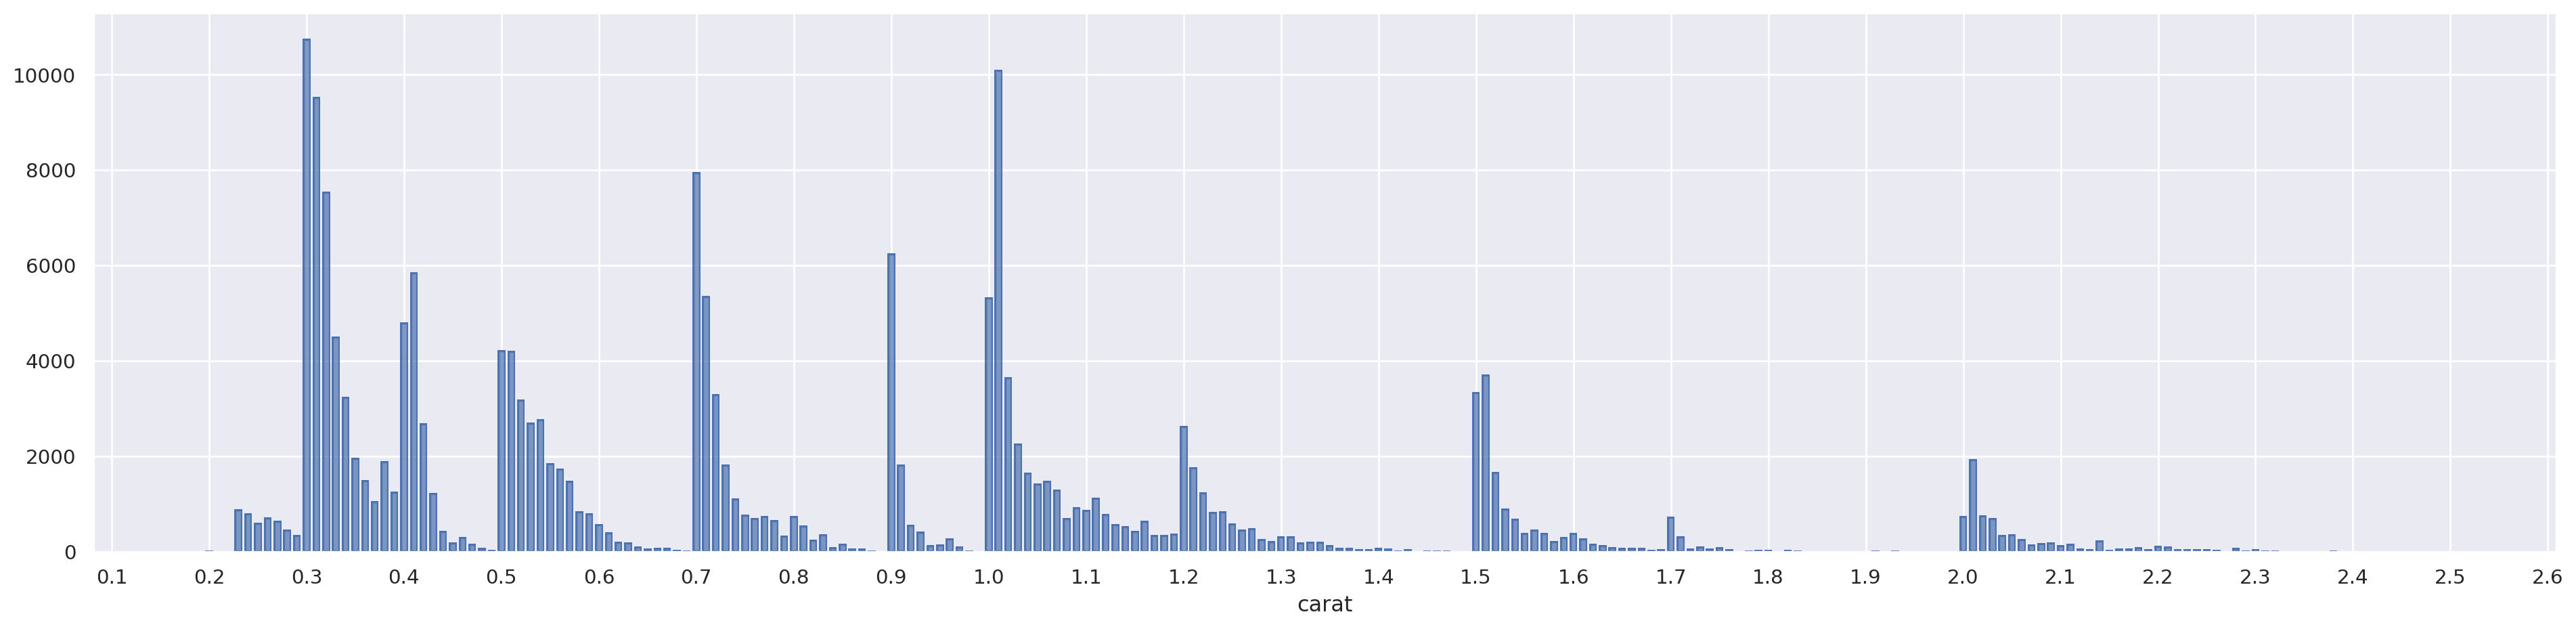

In [6]:
# plot carat histogram with seaborn so
min_carat = 0
max_carat = 2.5
df = df_train[(df_train["carat"] < max_carat) & (df_train["carat"] >= min_carat)]
(
    so.Plot(df, x="carat")
    .add(so.Bar(), so.Hist(binwidth=0.01, binrange=(min_carat-0.005, max_carat+0.005)))
    .scale(x=so.Continuous().tick(every=0.1))
    .layout(size=(20, 5))
)


In [7]:
# group by carat and find values where the count is greater than the previous bin
# this is a hack to find the bin edges

df = df_train
df = df.groupby("carat").count()[["id"]].sort_values("carat")
df["prev_count"] = df["id"].shift(1)
df["count_diff"] = df["id"] - df["prev_count"]
df["count_diff"] = df["count_diff"].fillna(0)
df["count_diff"] = df["count_diff"].astype(int)

df["bin_edge"] = (df["count_diff"] > 2 * df["prev_count"]) & (df["count_diff"] > 200)
df["bin_edge"] = df["bin_edge"].astype(int)
df["bin_edge"] = df["bin_edge"].cumsum()

# add column for distance to start of the bin
df = pd.merge(df.reset_index(), df.reset_index().groupby("bin_edge").first()["carat"], on="bin_edge", how="left", suffixes=("", "_start"))
df["carat_diff"] = df["carat"] - df["carat_start"]
# df["bin_edge"] = df["bin_edge"].astype(str)
# df["bin_edge"] = df["carat"].astype(str) + "-" + df["bin_edge"]
# df_train

df_train = pd.merge(df_train, df[["bin_edge","carat", "carat_diff"]], on="carat", how="left")
df_train

,id,carat,cut,color,clarity,depth,table,x,y,z,price,bin_edge,carat_diff
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619,9,0.02
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387,11,0.03
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772,5,0.00
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666,2,0.02
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453,10,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193568,193568,0.31,Ideal,D,VVS2,61.1,56.0,4.35,4.39,2.67,1130,2,0.01
193569,193569,0.70,Premium,G,VVS2,60.3,58.0,5.75,5.77,3.47,2874,5,0.00
193570,193570,0.73,Very Good,F,SI1,63.1,57.0,5.72,5.75,3.62,3036,5,0.03
193571,193571,0.34,Very Good,D,SI1,62.9,55.0,4.45,4.49,2.81,681,2,0.04


In [80]:
centre = 2.05
window = 0.1
df.loc[[2.0,2.01,2.02]]

,id,prev_count,count_diff,bin_edge
carat,,,,
2.00,745,6.0,739,14
2.01,1948,745.0,1203,14
2.02,760,1948.0,-1188,14


In [8]:
df_train["cut_rank"] = df_train["cut"].apply(cut_rank.index)
df_train["color_rank"] = df_train["color"].apply(color_rank.index)
df_train["clarity_rank"] = df_train["clarity"].apply(clarity_rank.index)

In [35]:
# Set up linear regression model to predict square root of price per carat
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = df_train.head(10000)
# df = df_train

# encode cut, color, clarity as rankhot encoding
def rankhot_encode(i, len_rank):
    return np.r_[np.ones(len_rank - i), np.zeros(i)]


def rankhot_encode_series(s, len_rank):
    return np.vstack(s.apply(lambda x: rankhot_encode(x, len_rank)))


X_rankhot = np.c_[
    rankhot_encode_series(df["cut_rank"], len(cut_rank)),
    rankhot_encode_series(df["color_rank"], len(color_rank)),
    rankhot_encode_series(df["clarity_rank"], len(clarity_rank)),
]


In [46]:
y = df["price"]

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X = np.c_[df["carat"], X_rankhot]
X = np.c_[X, df["carat_diff"]]
# X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train[:, 0] = X_train[:, 0]
price_shift = 0 #y_train.min()
transform_target = True
if transform_target:
    y_train = np.sqrt(y_train - price_shift) / X_train[:, 0]

def predict_prices(predictions, carats):
    if transform_target:
        return (predictions * carats) ** 2 + price_shift
    else:
        return predictions


In [48]:
# random forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred = y_pred * X_test[:, 0] + price_shift

print(
    "RMSE",
    mean_squared_error(
        y_test,
        predict_prices(rf.predict(X_test), X_test[:, 0]),
        squared=False,
    ),
)


RMSE 633.0989170910417


In [47]:
reg = LinearRegression().fit(X_train, y_train)
w = reg.coef_
b = reg.intercept_
print(w, b)


print(
    "RMSE",
    mean_squared_error(
        y_test,
        predict_prices(reg.predict(X_test), X_test[:, 0]),
        squared=False,
    ),
)


[-4.14810129e+00  0.00000000e+00  2.13640105e+00  1.24812848e+00
  7.02867136e-01  7.19937936e-01  3.55271368e-15  2.99437632e+00
  4.05901756e+00  3.18654101e+00  1.82155383e+00  1.71749349e+00
  1.73658036e+00  8.88178420e-16  0.00000000e+00 -1.99840144e-15
  6.01299067e+00  4.86903417e+00  5.47345231e+00  2.71647322e+00
  5.38523357e+00  4.26184349e+00  3.69794709e+00  0.00000000e+00
 -1.79296282e+01] 48.36312497893459
RMSE 727.5553728303009


In [26]:
# Alternative basic ordinals
df = df_train.head(10000)

X_base = np.c_[
    df["carat"],
    len(cut_rank) - df["cut_rank"],
    len(color_rank) - df["color_rank"],
    len(clarity_rank) - df["clarity_rank"],
    df["carat_diff"],
]
y_base = df["price"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

y_train_b = np.sqrt(y_train_b) / X_train_b[:, 0]

print(X_train_b.shape, y_train_b.shape)

reg = LinearRegression().fit(X_train_b, y_train_b)
w = reg.coef_
b = reg.intercept_
print(w, b)

print("RMSE", mean_squared_error(y_test_b, predict_prices(reg.predict(X_test_b) ,X_test_b[:,0]), squared=False))

(8000, 5) (8000,)
[ -4.29716646   0.87755513   2.4320815    4.52083084 -18.20234135] 36.74731690168074
RMSE 751.4744190745145


In [203]:
# Add predictions to df_train
X_all = np.c_[
    df_train["carat"],
    rankhot_encode_series(df_train["cut_rank"], len(cut_rank)),
    rankhot_encode_series(df_train["color_rank"], len(color_rank)),
    rankhot_encode_series(df_train["clarity_rank"], len(clarity_rank)),
]

In [ ]:
df_train["predicted_price"] = predict_prices(reg.predict(X_all), df_train["carat"])

/home/james/.pyenv/versions/3.7.16/envs/kaggle3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


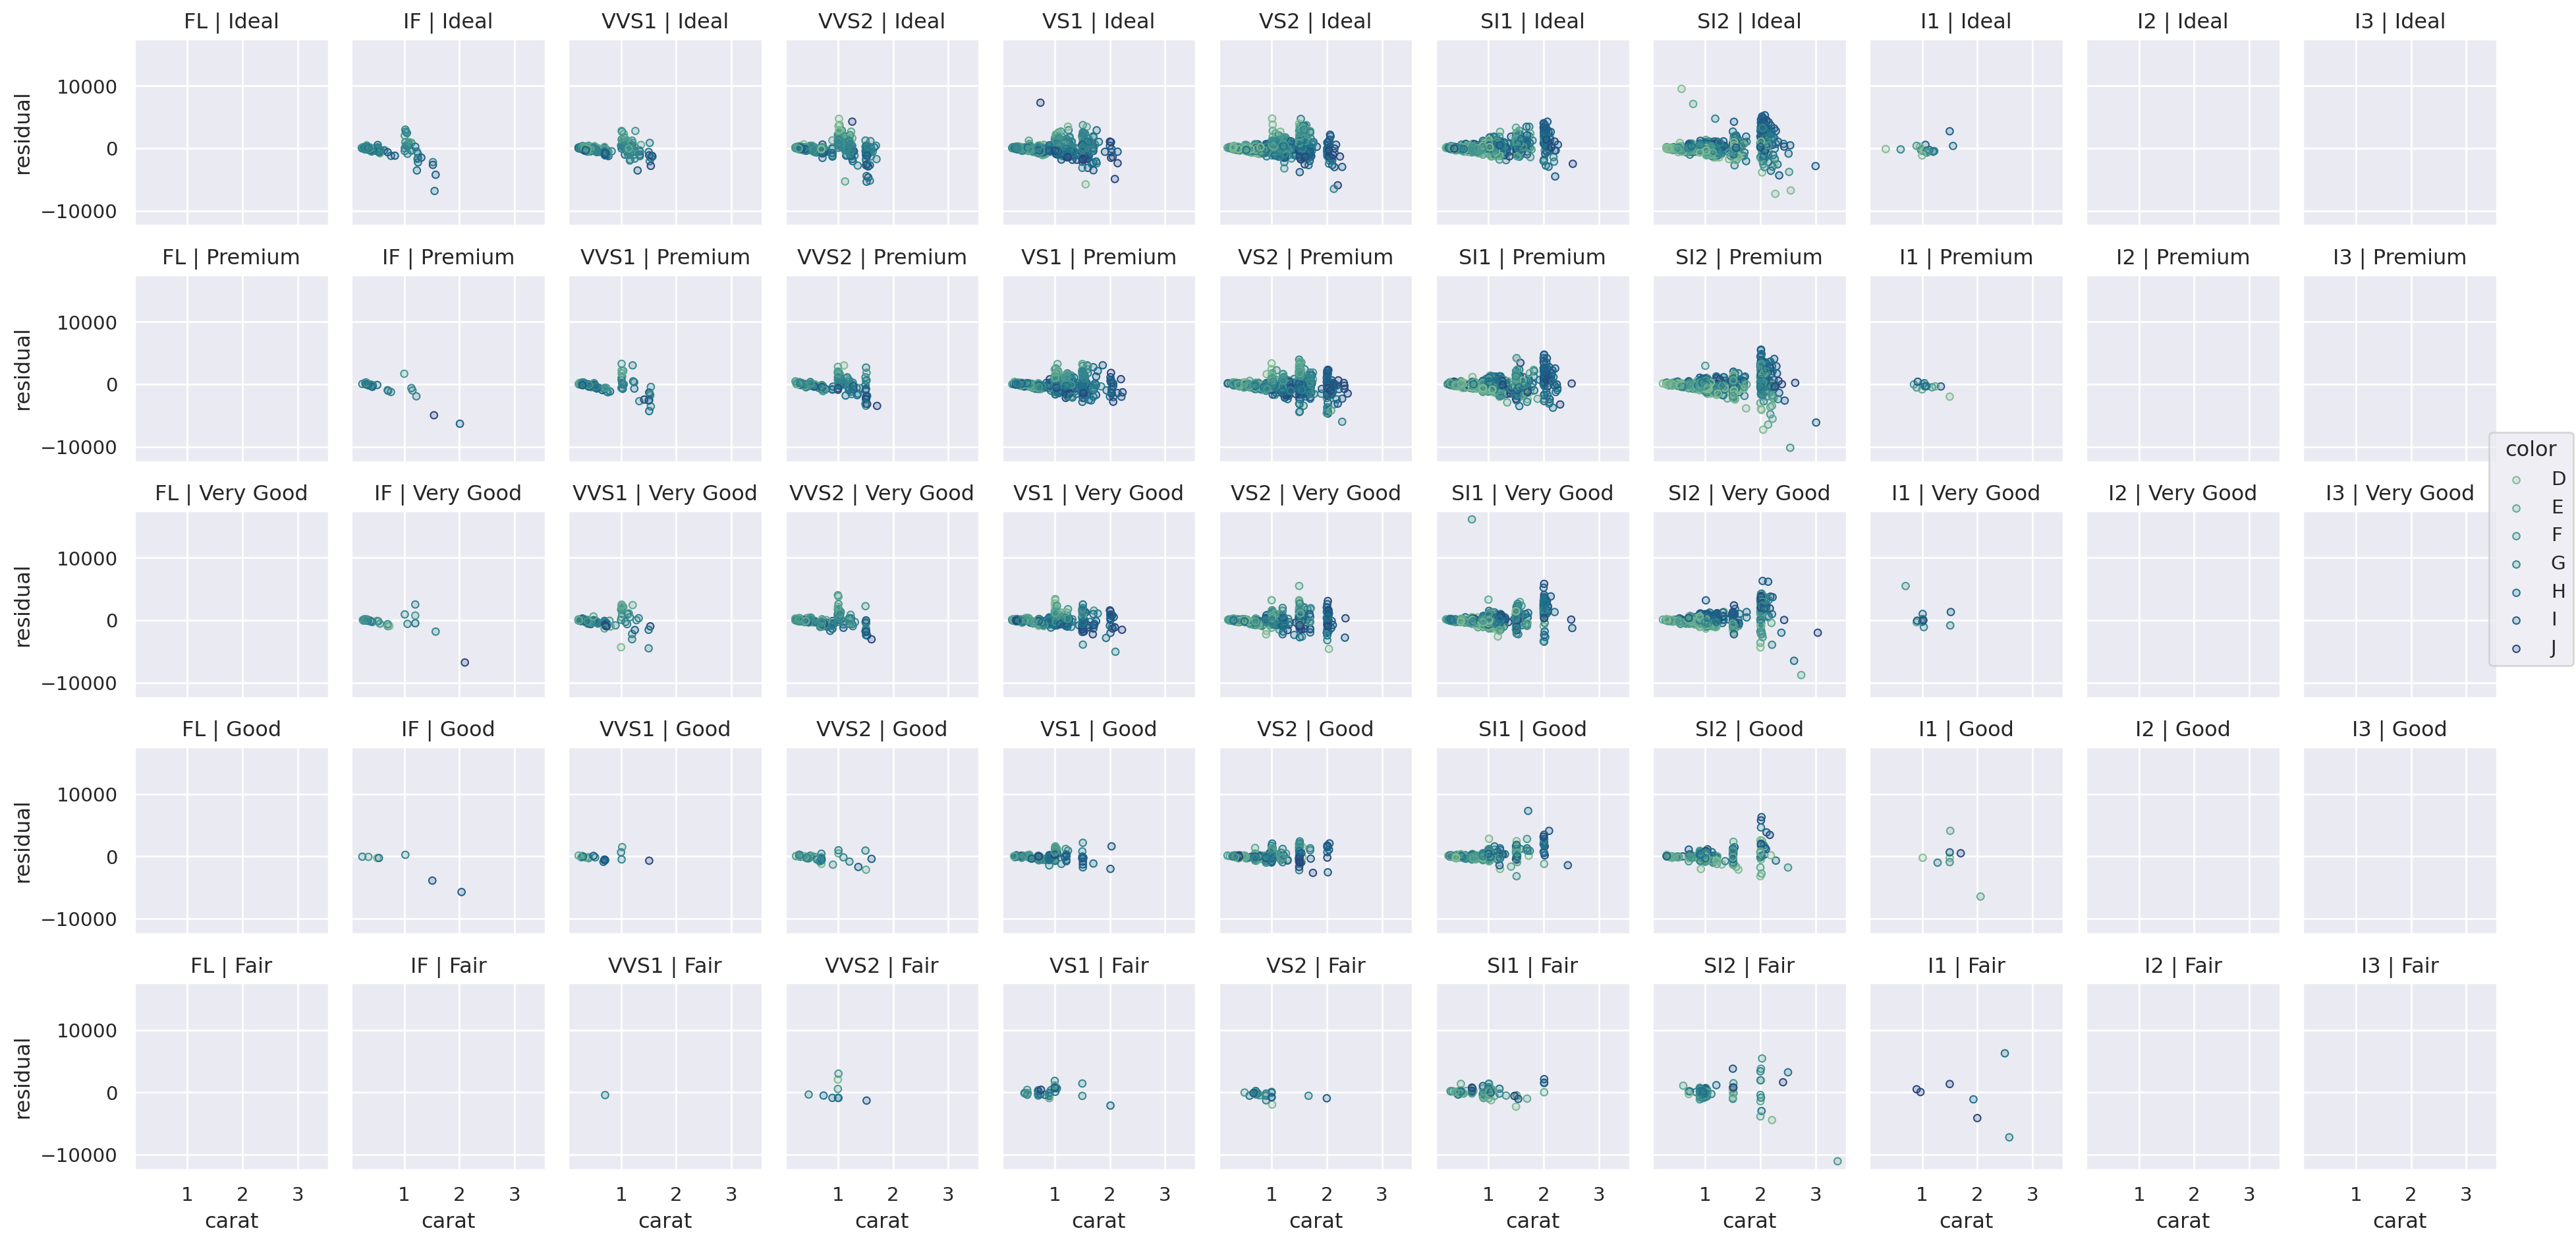

In [213]:
df = df_train.head(20000)

# Plot the residuals
df["residual"] = df["price"] - df["predicted_price"]
(
    so.Plot(df, x="carat", y="residual", color="color")
    .facet(col="clarity", row="cut", order={"col": clarity_rank, "row": cut_rank})
    .add(so.Dots())
    .scale(color=so.Nominal(values="crest", order=color_rank))
    .layout(size=(20, 10))
)


In [245]:
from sklearn.preprocessing import StandardScaler

df = df_train.head(20000)
features = ["bin_edge", "x", "y", "z"]# + ["cut_rank", "color_rank", "clarity_rank",]
X_mlp = df[features].to_numpy()
y_mlp = (df["price"]-df["predicted_price"]).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.2, random_state=42)

X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train[:,np.newaxis]).squeeze()

X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test[:,np.newaxis]).squeeze()

In [249]:
from models import MLP, NumpyDataset, Trainer
from torch import nn

dataset_train = NumpyDataset(X_train, y_train)
dataset_test = NumpyDataset(X_test, y_test)

model = MLP([len(features), 512, 100, 1], nn.ReLU)

trainer = Trainer(model) #dataset_train, dataset_test, batch_size=1000, lr=0.001)

results = []
for _acc, loss in trainer.train_loop(dataset_train, dataset_test, epochs=30):
    results.append(loss)
    print(len(results), f"Avg loss: {loss:>8f}")

Using cpu device
1 Avg loss: 0.920489
2 Avg loss: 0.913409
3 Avg loss: 0.905537
4 Avg loss: 0.899002
5 Avg loss: 0.896144
6 Avg loss: 0.890270
7 Avg loss: 0.888138
8 Avg loss: 0.882702
9 Avg loss: 0.886072
10 Avg loss: 0.889142
11 Avg loss: 0.885804
12 Avg loss: 0.886719
13 Avg loss: 0.886704
14 Avg loss: 0.885379
15 Avg loss: 0.887301
16 Avg loss: 0.883851
17 Avg loss: 0.884702
18 Avg loss: 0.882857
19 Avg loss: 0.885359
20 Avg loss: 0.881716
21 Avg loss: 0.882083
22 Avg loss: 0.881159
23 Avg loss: 0.880757
24 Avg loss: 0.880102
25 Avg loss: 0.879346
26 Avg loss: 0.881838
27 Avg loss: 0.879651
28 Avg loss: 0.879554
29 Avg loss: 0.881008
30 Avg loss: 0.877794
Done!


<AxesSubplot:>

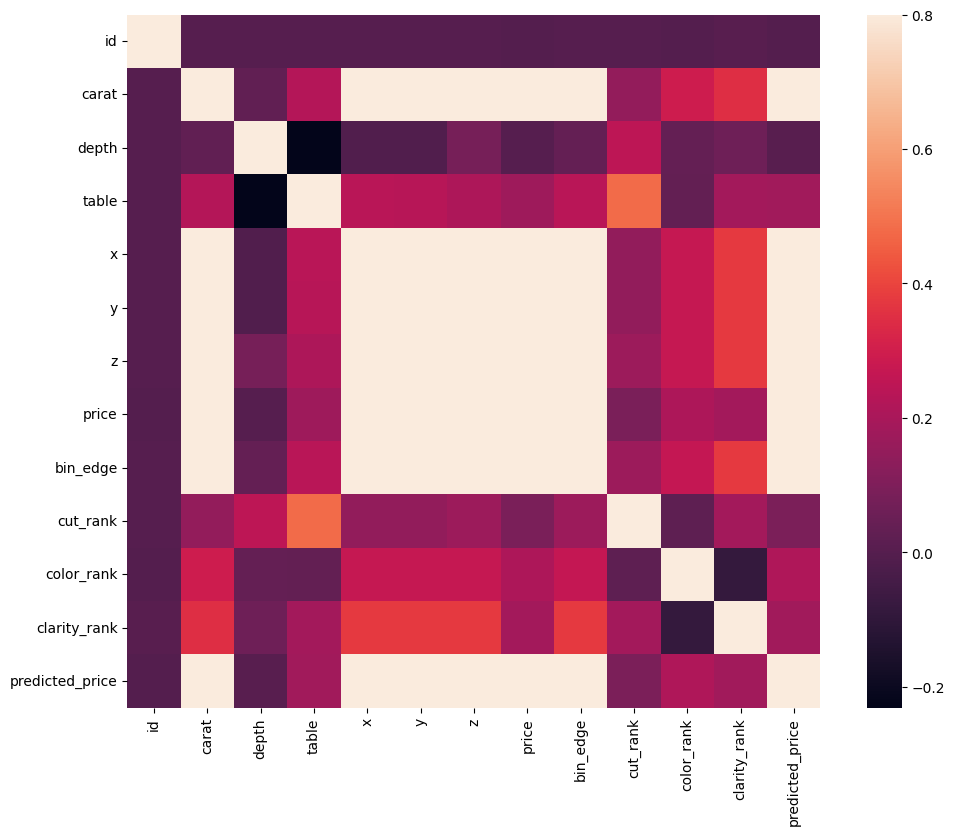

In [239]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)